## Packages

### Install

In [1]:
pip install numpy

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyreadstat

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install scipy

In [ ]:
pip install seaborn

In [ ]:
pip install plotly

In [ ]:
pip install -U scikit-learn

In [ ]:
pip install boruta

In [ ]:
pip install -U imbalanced-learn

In [79]:
pip install -U statsmodels

  Using cached statsmodels-0.12.2-cp38-none-win_amd64.whl (9.4 MB)
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Behzad\\anaconda3\\envs\\BP1\\Lib\\site-packages\\statsmodels\\tsa\\statespace\\tests\\results\\frbny_nowcast\\test_dfm_112.mat'
Consider using the `--user` option or check the permissions.



### Import

In [3]:
import numpy as np # for scientific computing
import pandas as pd # a fundamental and powerful package for data analysis and manipulation
import seaborn as sns # seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import pyreadstat # for reading .sav file
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, LeaveOneOut, train_test_split # for separating train and test data, scaling, model building, ...
from scipy import stats # it contains a large number of statistics, probability distributions functions
import matplotlib.pyplot as plt # matplotlib is a library to plot graphs in Python
from sklearn.impute import KNNImputer # Imputation for completing missing values using k-Nearest Neighbors
from sklearn.experimental import enable_iterative_imputer # Enables IterativeImputer. The API and results of this estimator might change without any deprecation cycle
from sklearn.impute import IterativeImputer # Multivariate imputer that estimates each feature from all the others. A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion
from sklearn.ensemble import RandomForestClassifier # A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting
from boruta import BorutaPy # Boruta is an all relevant feature selection method, while most other are minimal optimal; this means it tries to find all features carrying information usable for prediction, rather than finding a possibly compact subset of features on which some classifier has a minimal error
from imblearn.over_sampling import SMOTE # Implementation of SMOTE - Synthetic Minority Over-sampling Technique
from collections import Counter # A Counter is a container that keeps track of how many times equivalent values are added
from sklearn.metrics import plot_confusion_matrix # plot confusion matrix
from sklearn.metrics import accuracy_score # Accuracy classification score

## 1. Read Data

In [42]:
# reading data as a data frame, setting ID as the index and getting the number of rows and columns
df = pd.DataFrame(pd.read_spss("../data/secom_mod.sav"))
df = df.set_index('ID')
df.shape

(1567, 592)

## 2. Explore data

#### 2.1. Shape and type

In [43]:
# shape of the data set
print('Shape: ',df.shape)  

Shape:  (1567, 592)


In [44]:
# checking data types of the features
print(df.info(),"\n")
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1567 entries, 1.0 to 1567.0
Columns: 592 entries, class to feature590
dtypes: float64(591), object(1)
memory usage: 7.1+ MB
None 

class         float64
timestamp      object
feature001    float64
feature002    float64
feature003    float64
               ...   
feature586    float64
feature587    float64
feature588    float64
feature589    float64
feature590    float64
Length: 592, dtype: object


#### 2.2. Duplicates

In [45]:
# Check for duplicated rows
df.index.duplicated().any()

False

In [46]:
#Check for duplicated columns
#df.columns.duplicated().any()

#### 2.3. Pass / Fail ratio

In [47]:
# number of pass and fail values
df['class'].value_counts()

0.0    1472
1.0      95
Name: class, dtype: int64

In [48]:
# pie chart of the target variable
def ClassDistributionGraph(df, title):
    %matplotlib inline
    plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})
    
    labels = ['Pass', 'Fail']
    distribution = df.value_counts()
    colors = ['lightblue', 'yellowgreen']

    # Plot
    plt.pie(distribution, labels=labels, colors=colors, autopct= lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*distribution.sum()), shadow=True, startangle=140,)
    plt.title(title, fontsize=15)
    plt.axis('equal')
    plt.show()

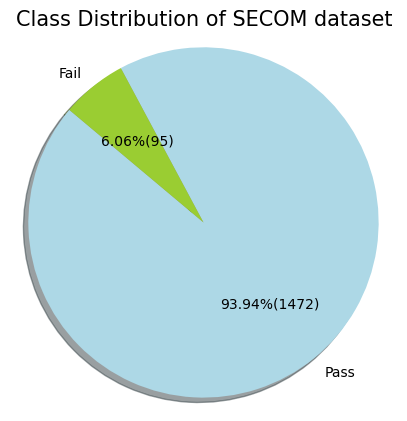

In [49]:
ClassDistributionGraph(df['class'], 'Class Distribution of SECOM dataset')

#### 2.4. Histogram of features

23 9 8 3


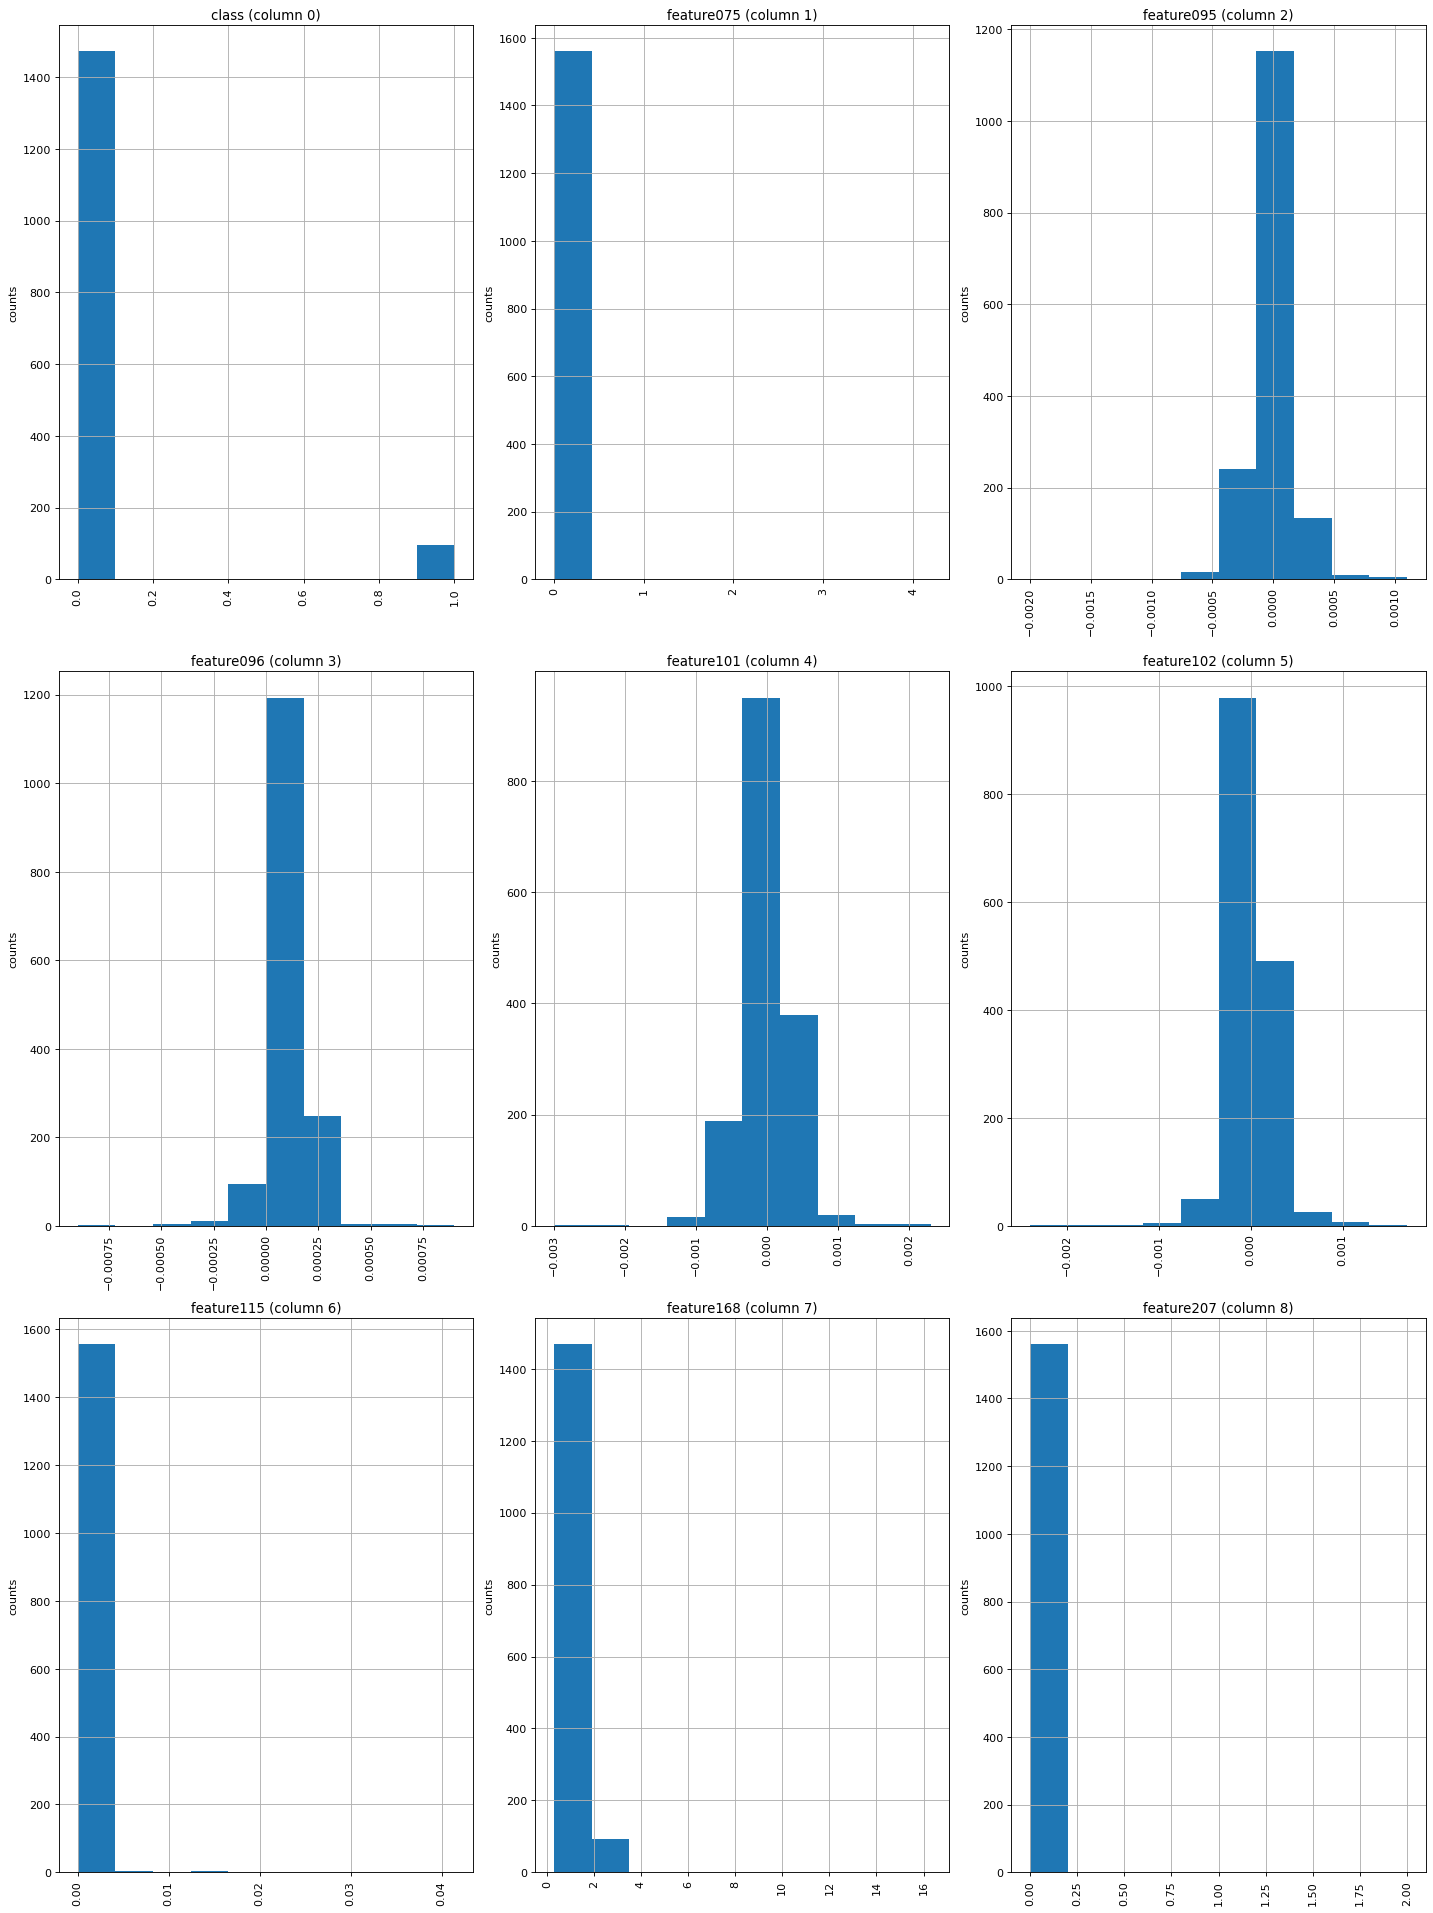

In [50]:
# histogram of some of the features
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    %matplotlib inline
    plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':100})
 
    
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    %matplotlib inline
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
   
    print(nCol, nGraphShown, nGraphRow, nGraphPerRow)
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

plotPerColumnDistribution(df, 9, 3)

#### 2.5. Correlation

In [51]:
# Correlation Histogram

def correlation(df):
    cor_matrix = pd.DataFrame(df.corr())

    # Remove reuntant values by selecting only the upper correlation triangle
    upper_tri = pd.DataFrame(cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool)))

    # Convert the upper correlation triangle to a Series
    corlist = pd.Series(upper_tri.values.ravel('F'))

    # Correlation Histogram
    %matplotlib inline
    plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':100})

    # Plot Histogram on x
    plt.hist(corlist, bins =50)
    plt.gca().set(title='Frequency Histogram of Correlation', ylabel='Frequency', xlabel='Correlation coefficient');

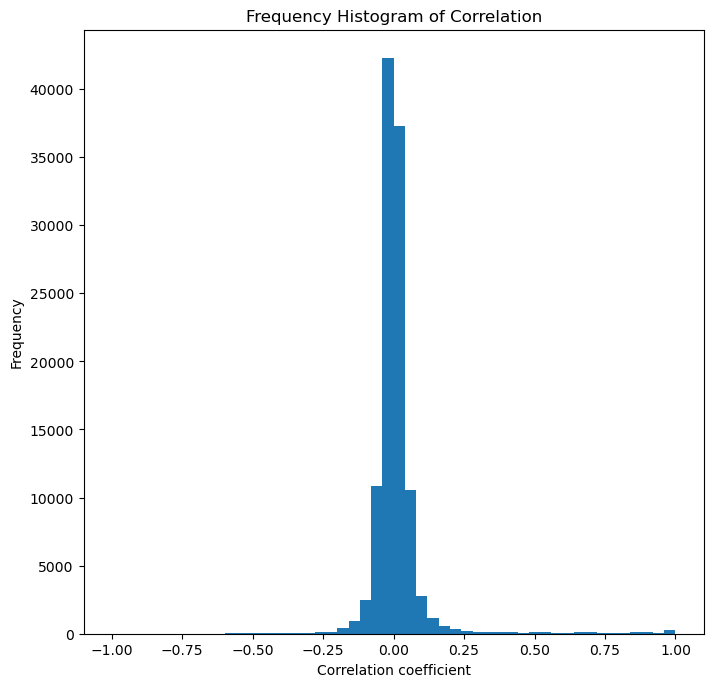

In [52]:
correlation(df)

#### 2.6. Missing values

In [53]:
# Total number of Nan values in the dataframe
df.isna().sum().sum()

41951

In [54]:
#number of cols with Nan values
nan_cols = [i for i in df.columns if df[i].isnull().any()]
print('number of columns with missing values = ', len(nan_cols))

#number of rows with Nan values
nan_rows = df.apply(lambda x: sum(x.isnull().values), axis = 1) # For rows
print('number of rows with missing values = ', len(nan_rows))

number of columns with missing values =  538
number of rows with missing values =  1567


## 3. Preprocessing

In [55]:
# Give text labels to the training examples
df['class'] = df['class'].replace({0: "PASS", 1: "FAIL"})
df.tail()

,class,timestamp,feature001,feature002,feature003,feature004,feature005,feature006,feature007,feature008,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
ID,,,,,,,,,,,,,,,,,,,,,
1563.0,PASS,16/10/2008 15:13:00,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,...,0.0047,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720
1564.0,PASS,16/10/2008 20:49:00,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,...,NaN,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720
1565.0,PASS,17/10/2008 05:26:00,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,...,0.0025,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231
1566.0,PASS,17/10/2008 06:01:00,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,...,0.0075,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941
1567.0,PASS,17/10/2008 06:07:00,2944.92,2450.76,2195.4444,2914.1792,1.5978,100.0,85.1011,0.1235,...,0.0045,137.7844,0.4987,0.0181,0.0040,3.6275,0.0117,0.0162,0.0045,137.7844


## 4. Data Preparation

### 4.1.Splitting Traninig and Test Data

In [56]:
# Split df into X and y
y = df['class']
X = df.drop('class', axis=1)

In [57]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle=True, random_state=40, stratify=y)

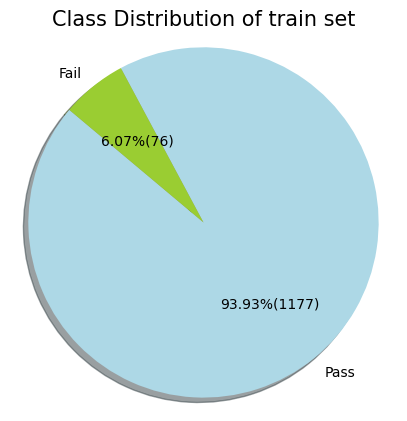

In [58]:
# pie chart for the train set
ClassDistributionGraph(y_train, 'Class Distribution of train set')

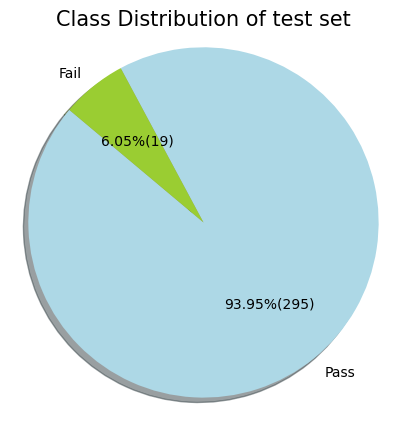

In [59]:
# pie chart for the test set
ClassDistributionGraph(y_test, 'Class Distribution of test set')

### 4.2 Rough feature reduction

#### 4.2.1 Removal of timestamp

In [60]:
# removing timestamp
X_train= X_train.drop(columns='timestamp')

#### 4.2.2 Removal of constants

In [61]:
#columns that have the same value excluding nan
print(len(X_train.columns[X_train.nunique() == 1]))

#column names with same value in it
X_train.columns[X_train.nunique() == 1]
print(list(X_train.columns[X_train.nunique() == 1]))

#remove these columns since it adds no value
single_value_columns = list(X_train.columns[X_train.nunique() == 1])
X_train=X_train.drop(columns=single_value_columns)
X_train

116
['feature006', 'feature014', 'feature043', 'feature050', 'feature053', 'feature070', 'feature098', 'feature142', 'feature150', 'feature179', 'feature180', 'feature187', 'feature190', 'feature191', 'feature192', 'feature193', 'feature194', 'feature195', 'feature227', 'feature230', 'feature231', 'feature232', 'feature233', 'feature234', 'feature235', 'feature236', 'feature237', 'feature238', 'feature241', 'feature242', 'feature243', 'feature244', 'feature257', 'feature258', 'feature259', 'feature260', 'feature261', 'feature262', 'feature263', 'feature264', 'feature265', 'feature266', 'feature267', 'feature277', 'feature285', 'feature314', 'feature315', 'feature316', 'feature323', 'feature326', 'feature327', 'feature328', 'feature329', 'feature330', 'feature331', 'feature365', 'feature370', 'feature371', 'feature372', 'feature373', 'feature374', 'feature375', 'feature376', 'feature379', 'feature380', 'feature381', 'feature382', 'feature395', 'feature396', 'feature397', 'feature398', '

,feature001,feature002,feature003,feature004,feature005,feature007,feature008,feature009,feature010,feature011,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
ID,,,,,,,,,,,,,,,,,,,,,
567.0,3023.07,2484.55,2242.8555,1430.7270,0.8832,106.2100,0.1216,1.5613,-0.0028,0.0008,...,NaN,NaN,0.4979,0.0165,0.0041,3.3098,0.0184,0.0127,0.0037,68.7057
1261.0,2953.63,2384.04,2191.2111,1437.5003,2.2073,97.6444,0.1235,1.3584,-0.0024,-0.0048,...,NaN,NaN,0.4968,0.0188,0.0041,3.7853,0.0137,0.0326,0.0108,237.4625
1041.0,3021.61,2440.29,2227.2222,2043.5876,1.1892,95.5267,0.1253,1.5335,-0.0083,-0.0095,...,NaN,NaN,0.5091,0.0123,0.0031,2.4116,0.0437,0.0200,0.0074,45.7019
1181.0,3093.46,2479.17,2221.3667,2490.6947,1.2667,88.6578,0.1220,1.3537,0.0134,-0.0039,...,NaN,NaN,0.5006,0.0148,0.0036,2.9659,0.0190,0.0150,0.0045,78.6525
611.0,3010.40,NaN,2172.4000,1148.4101,1.2614,102.4522,0.1227,1.3843,-0.0010,-0.0004,...,NaN,NaN,0.5015,0.0137,0.0034,2.7339,0.0252,0.0157,0.0046,62.3881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806.0,2952.31,2453.53,2188.7222,1325.5230,1.1721,105.1700,0.1250,1.4480,-0.0233,0.0087,...,NaN,NaN,0.4949,0.0155,0.0034,3.1238,0.0253,0.0058,0.0018,22.7661
1101.0,2880.58,2489.76,2256.6000,2365.4787,1.1384,85.4278,0.1205,1.6114,0.0484,0.0043,...,0.0076,50.7949,0.5032,0.0117,0.0029,2.3282,0.0398,0.0202,0.0076,50.7949
1469.0,2968.78,2451.53,2207.1000,1298.4309,1.0251,96.9478,0.1203,1.3985,-0.0105,-0.0140,...,0.0084,185.3578,0.4972,0.0133,0.0036,2.6718,0.0167,0.0310,0.0084,185.3578


#### 4.2.3. Checking for columns more than 55% nan values

In [62]:
# count the number of missing values for each column
num_missing = pd.DataFrame((X_train.isna()).sum())
print(num_missing.sort_values(0))

               0
feature360     0
feature223     0
feature224     0
feature249     0
feature250     0
...          ...
feature359  1078
feature294  1140
feature158  1140
feature159  1140
feature293  1140

[474 rows x 1 columns]


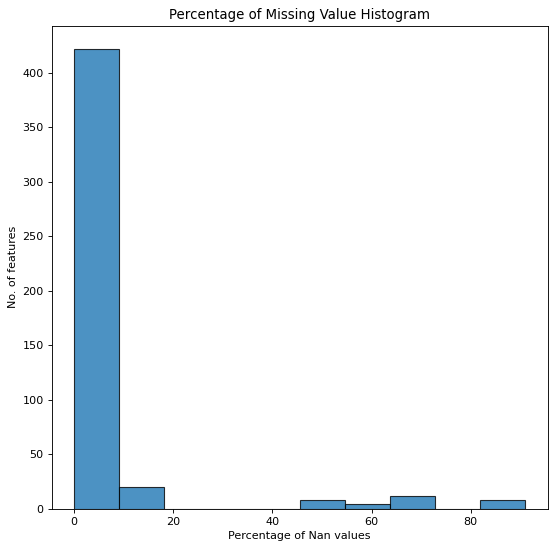

In [63]:
# Missing Value histogram
nan_perc = pd.DataFrame(round((X_train.isnull().sum() * 100/ len(X_train)),2))
nan_perc = nan_perc.reset_index()
nan_perc = nan_perc.rename({'index': 'feature', 0: 'percentage'}, axis=1)

%matplotlib inline
plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':80})
n,bins,patch = plt.hist(nan_perc['percentage'],bins=10, alpha=0.8, label='Value', edgecolor='black', linewidth=1)
plt.gca().set(title='Percentage of Missing Value Histogram', ylabel='No. of features', xlabel='Percentage of Nan values');
plt.show()

In [64]:
# Defining a threshold to remove the values above it
threshold= 0.55
pct_null = X_train.isnull().sum() / len(X_train)
missing_value_cols = pct_null[pct_null >= threshold].index

# number of features containing more than 55% missing values
print(len(missing_value_cols))
print(missing_value_cols)

X_train = X_train.drop(missing_value_cols, axis=1)

24
Index(['feature086', 'feature110', 'feature111', 'feature112', 'feature158',
       'feature159', 'feature221', 'feature245', 'feature246', 'feature247',
       'feature293', 'feature294', 'feature359', 'feature383', 'feature384',
       'feature385', 'feature493', 'feature517', 'feature518', 'feature519',
       'feature579', 'feature580', 'feature581', 'feature582'],
      dtype='object')


#### 4.2.5. Less volatile

In [65]:
# Exploring  remaining features
summary = X_train.iloc[:,:].describe(include='all')

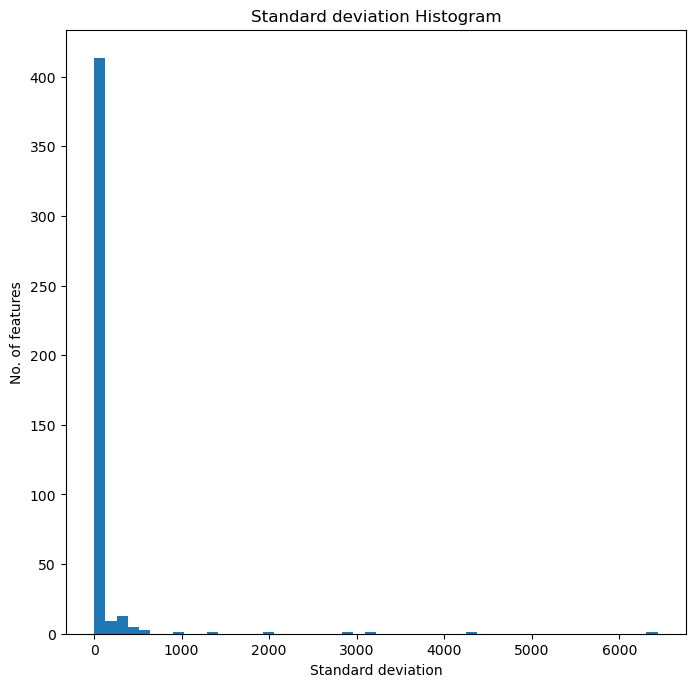

In [66]:
# Checking std of remaining features

def StandardDeviation(df):
    import matplotlib.pyplot as plt

    %matplotlib inline
    plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':100})

    plt.hist(df.std(), bins = 50)
    plt.gca().set(title='Standard deviation Histogram', ylabel='No. of features', xlabel='Standard deviation');
    plt.show()
    
StandardDeviation(X_train)

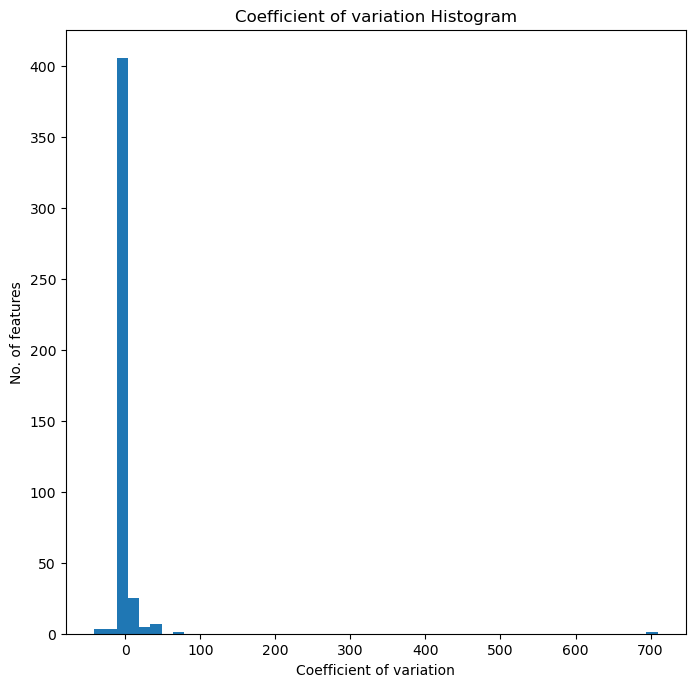

In [67]:
# Checking coeff std of remaining features
def CoefficientOfVariation(df):
    %matplotlib inline
    plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':100})

    plt.hist(df.std()/df.mean(), bins = 50)
    plt.gca().set(title='Coefficient of variation Histogram', ylabel='No. of features', xlabel='Coefficient of variation');
    plt.show()

CoefficientOfVariation(X_train)

<AxesSubplot:>

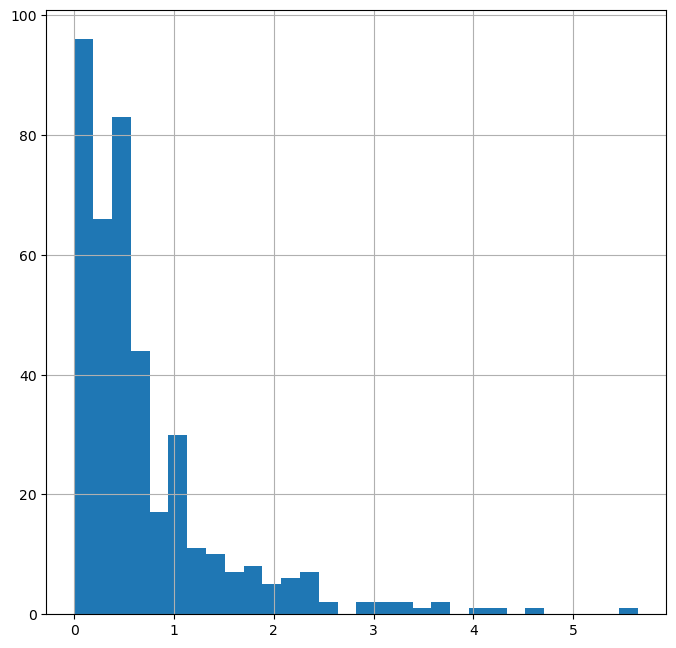

In [68]:
# histogram of the coefficient standard deviation of a percentage of features with the least coeffstd
feature_coeffstd = pd.DataFrame(summary.loc['std',:]/abs(summary.loc['mean',:])).sort_values(by=[0])
percentage_features = int(len(feature_coeffstd)*90/100)
feature_coeffstd.iloc[0:percentage_features,0].hist(bins=30)

In [69]:
# a percentage of features with the least coeffstd to remove
percentageToAnalyze = 5

percentage_features_rm = int(len(feature_coeffstd)*percentageToAnalyze/100)
feature_index = feature_coeffstd.index
features_least_volatile = feature_index[0:percentage_features_rm+1]
print("Number of least Volatiles", len(features_least_volatile))
print(features_least_volatile)

Number of least Volatiles 23
Index(['feature132', 'feature058', 'feature038', 'feature039', 'feature122',
       'feature134', 'feature583', 'feature124', 'feature125', 'feature057',
       'feature120', 'feature056', 'feature117', 'feature054', 'feature021',
       'feature055', 'feature088', 'feature548', 'feature114', 'feature003',
       'feature018', 'feature012', 'feature119'],
      dtype='object')


In [70]:
# dropping a percentage of features with the least coeffstd
X_train.drop(features_least_volatile, axis = 1, inplace = True)

### 4.3 Outlier Identification

In [71]:
X_train.isna().sum().sum()

10888

In [72]:
def Outlier(X,outlier_method) :

    # calculating the z score of the values
    z_train= pd.DataFrame(stats.zscore(X,nan_policy='omit'))
    z_train

    # calculating the number of outliers
    print('Number of Outliers : ',sum(z_train.apply(lambda x: sum(x.apply(lambda x: 1 if abs(x)>3 else 0)))))

    #Outlier treatment : replacing outliers with NA to impute all NA values
    is_outlier = abs(z_train)>3
    is_outlier.columns = X.columns
    is_outlier.index = X.index
    
    if outlier_method == 'NaN':        
        return(X.mask(is_outlier, np.nan))   
    elif  outlier_method == '3s':
        return(X.mask(is_outlier, 3*np.std))

X_train = Outlier(X_train,'NaN')

Number of Outliers :  4724


In [73]:
#NA values in the dataset
X_train.isna().sum().sum()

15612

### 4.4 Missing value Imputation

In [74]:
# function for imputing missing values
def MissingValueImputation(X, Imputer, Imputer_Parameters) :
    
    if Imputer == 'KNN' :
        
        #define imputer
        KNN_imputer = KNNImputer(n_neighbors=Imputer_Parameters, weights = 'uniform')

        #fit on the dataset
        return(KNN_imputer.fit_transform(X))
        
    elif Imputer == 'MICE' :
        
        #define imputer
        MICE_imputer = IterativeImputer(max_iter=Imputer_Parameters, random_state=0)
        
        #fit dataset
        return(MICE_imputer.fit_transform(X))


#### 4.4.1. KNN

In [75]:
# impute using knn
X_train_KNN = X_train.copy(deep=True)
X_train_KNN.iloc[:,:] = pd.DataFrame(MissingValueImputation(X_train,'KNN',10))

#### 4.4.2. MICE

In [80]:
# impute using mice
X_train_MICE = X_train.copy(deep=True)
X_train_MICE.iloc[:,:] = pd.DataFrame(MissingValueImputation(X_train,'MICE',20))

C:\Users\Behzad\anaconda3\envs\BP1\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


### 4.5. Evaluation of imputation

#### 4.5.1. Fitting a linear model and comparing R-squared

In [83]:
#fit a linear model for statistical summary
import statsmodels.api as sm

# Copy of a complete train datatset (Dropping cols with Nan values)
X_train_cc = X_train.fillna(0)

X_lm = sm.add_constant(X_train_cc.iloc[:, :])
y_lm = y_train.replace({"PASS": 0, "FAIL" :1})

# fitting regression model for non imputed data set
lm_complete  = sm.OLS(y_lm, X_lm).fit()

# fitting regression model for knn imputed data set
X_lm = sm.add_constant(X_train_KNN.iloc[:, :])
lm_KNN = sm.OLS(y_lm, X_lm).fit()

# fitting regression model for mice imputed data set
X_lm = sm.add_constant(X_train_MICE.iloc[:, :])
lm_MICE = sm.OLS(y_lm, X_lm).fit()

In [84]:
# R squared comparison
print(pd.DataFrame({'Complete': lm_complete.rsquared_adj,
'KNN Imp.': lm_KNN.rsquared_adj,
'MICE Imp.': lm_MICE.rsquared_adj},
index=['R_squared_adj']))

               Complete  KNN Imp.  MICE Imp.
R_squared_adj  0.163781  0.161576   0.148883


#### 4.5.2 Density plots

8


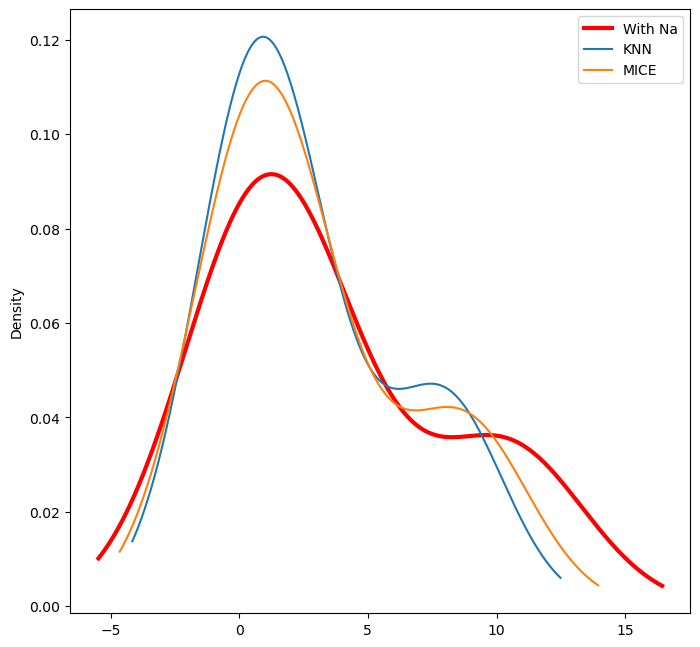

In [89]:
# plot the std of the features with more than 3% of missing values before and after imputation with knn and mice
feature_missing_sum = pd.DataFrame((X_train.isna()).sum())
percentage_missing_filter = 20/100
feature_filter = feature_missing_sum[feature_missing_sum[0]>=(len(X_train.loc[:,])*percentage_missing_filter)].index

print(len(feature_filter))

summary_with_na = X_train[feature_filter].describe(include='all')
feature_std_with_na = pd.DataFrame(summary_with_na.loc['std',:])
feature_std_sort_with_na = feature_std_with_na.sort_values(by=['std'])

summary_knn = X_train_KNN[feature_filter].describe(include='all')
feature_std_knn = pd.DataFrame(summary_knn.loc['std',:])
feature_std_sort_knn = feature_std_knn.sort_values(by=['std'])

summary_mice = X_train_MICE[feature_filter].describe(include='all')
feature_std_mice = pd.DataFrame(summary_mice.loc['std',:])
feature_std_sort_mice = feature_std_mice.sort_values(by=['std'])

feature_std_sort_with_na.iloc[:,0].plot(kind='kde',c='red',linewidth=3)
feature_std_sort_knn.iloc[:,0].plot(kind='kde')
feature_std_sort_mice.iloc[:,0].plot(kind='kde')
labels = ['With Na', 'KNN','MICE']
plt.legend(labels)

### Visualizing using t-SNE

In [137]:
from sklearn.manifold import TSNE
m = TSNE(learning_rate=50)

In [153]:
X_tsne = X_train_KNN.merge(y_lm, left_index= True, right_index= True)
tsne_features = m.fit_transform(X_tsne)
tsne_features = pd.DataFrame(tsne_features, columns=['x','y'])
tsne_features

,x,y
0,-17.347357,0.904460
1,2.669212,-4.243263
2,11.131304,-42.103119
3,23.133623,26.868004
4,28.522179,9.383171
...,...,...
1248,20.313667,14.635294
1249,20.946196,-16.326818
1250,18.497192,40.305916
1251,-31.621117,26.266897


<AxesSubplot:xlabel='x', ylabel='y'>

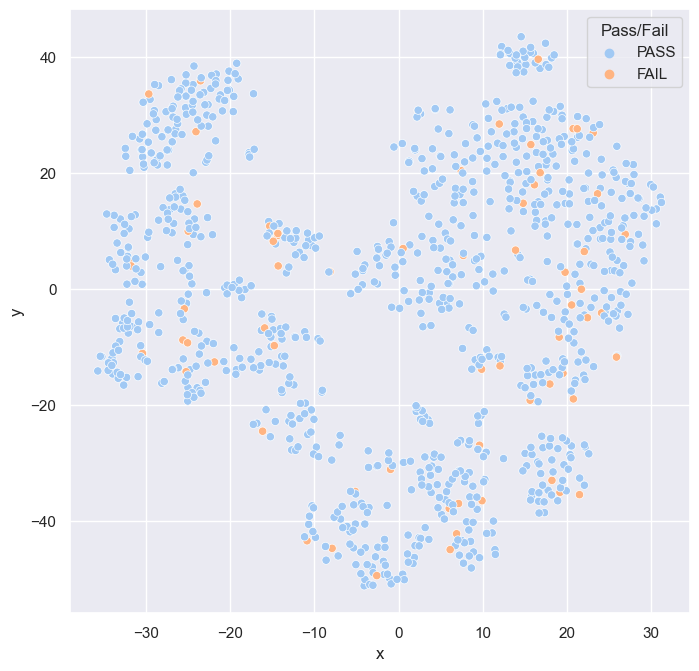

In [176]:
X_tsne['Pass/Fail'] = X_tsne['Pass/Fail'].replace({0: "PASS", 1: "FAIL"})
sns.scatterplot(data = tsne_features , x='x' , y='y', hue= X_tsne['Pass/Fail'], legend= True )


## 4.6. Feature Selection

### 4.6.1 Boruta

In [51]:
def FeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
    model.fit(X, y)
    
    # define Boruta feature selection method
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)

    # find all relevant features
    feature_selector.fit(X.to_numpy(),y)

    # check selected features
    feature_selector.support_

    # check ranking of features
    feature_selector.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             feature_selector.ranking_, 
                             feature_selector.support_))

    # print the results
    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.support_ == True)
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    print(final_features)
    
    
    # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features)) , final_features


In [52]:
# apply Boruta and store selected features in the variable
X_train_KNN_Boruta , final_features_KNN = FeatureSelection(X_train_KNN,y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	403
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	21
Rejected: 	403
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	21
Rejected: 	403
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	21
Rejected: 	403
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	18
Rejected: 	403
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	18
Rejected: 	403
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	18
Rejected: 	403
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	18
Rejected: 	403
Iteration: 	16 / 100
Confirmed: 	6
Tentat

#### 4.6.2 Overview of remaining features


In [54]:
# Descriptive statistics
X_train_KNN_Boruta.describe()

,feature029,feature034,feature041,feature060,feature066,feature104,feature126,feature127,feature131,feature161,feature248,feature296,feature432,feature461,feature478,feature511
count,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000
mean,69.501848,8.823478,67.975162,2.751658,26.823964,-0.009804,1.180836,2.732178,0.746817,458.171269,0.044818,204.011977,17.657233,28.734056,5.686452,52.233993
std,3.469649,0.399933,23.851831,8.136815,5.745666,0.002826,0.262669,0.203648,0.080722,241.620781,0.037540,107.283669,12.497290,11.836437,2.321834,24.460922
min,59.888900,7.603200,1.434000,-21.205500,8.763600,-0.018500,0.605500,2.340000,0.501300,28.000000,0.000000,13.622900,1.239100,7.953400,1.687200,0.000000
25%,67.388900,8.578800,74.480000,-1.882700,23.059600,-0.011800,0.979100,2.575000,0.688700,294.000000,0.023100,130.220300,11.051200,20.363900,4.098700,35.320100
50%,69.133300,8.767700,78.300000,0.860000,26.281000,-0.010100,1.144000,2.734000,0.758600,430.000000,0.035400,192.546270,16.097600,26.277700,5.242200,46.975100
75%,72.266700,9.040200,80.260000,4.381800,29.910300,-0.008100,1.338000,2.857000,0.818700,600.000000,0.050540,263.326600,21.264700,35.173600,6.698400,63.636400
max,77.344400,10.963400,86.120000,29.750900,49.023700,-0.000700,2.022000,3.463000,0.888400,2113.000000,0.250000,997.684300,119.356000,70.261900,23.100200,160.493800


In [55]:
#datatype and shape
print(X_train_KNN_Boruta.info())
print(X_train_KNN_Boruta.shape)

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1253 entries, 567.0 to 645.0
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature029  1253 non-null   float64
 1   feature034  1253 non-null   float64
 2   feature041  1253 non-null   float64
 3   feature060  1253 non-null   float64
 4   feature066  1253 non-null   float64
 5   feature104  1253 non-null   float64
 6   feature126  1253 non-null   float64
 7   feature127  1253 non-null   float64
 8   feature131  1253 non-null   float64
 9   feature161  1253 non-null   float64
 10  feature248  1253 non-null   float64
 11  feature296  1253 non-null   float64
 12  feature432  1253 non-null   float64
 13  feature461  1253 non-null   float64
 14  feature478  1253 non-null   float64
 15  feature511  1253 non-null   float64
dtypes: float64(16)
memory usage: 166.4 KB
None
(1253, 16)


In [203]:
def HistogramSubplot(df, nRows, nColumns) :
    fig, axis = plt.subplots(nRows,nColumns,figsize=(10, 20))
    df.hist(ax=axis)

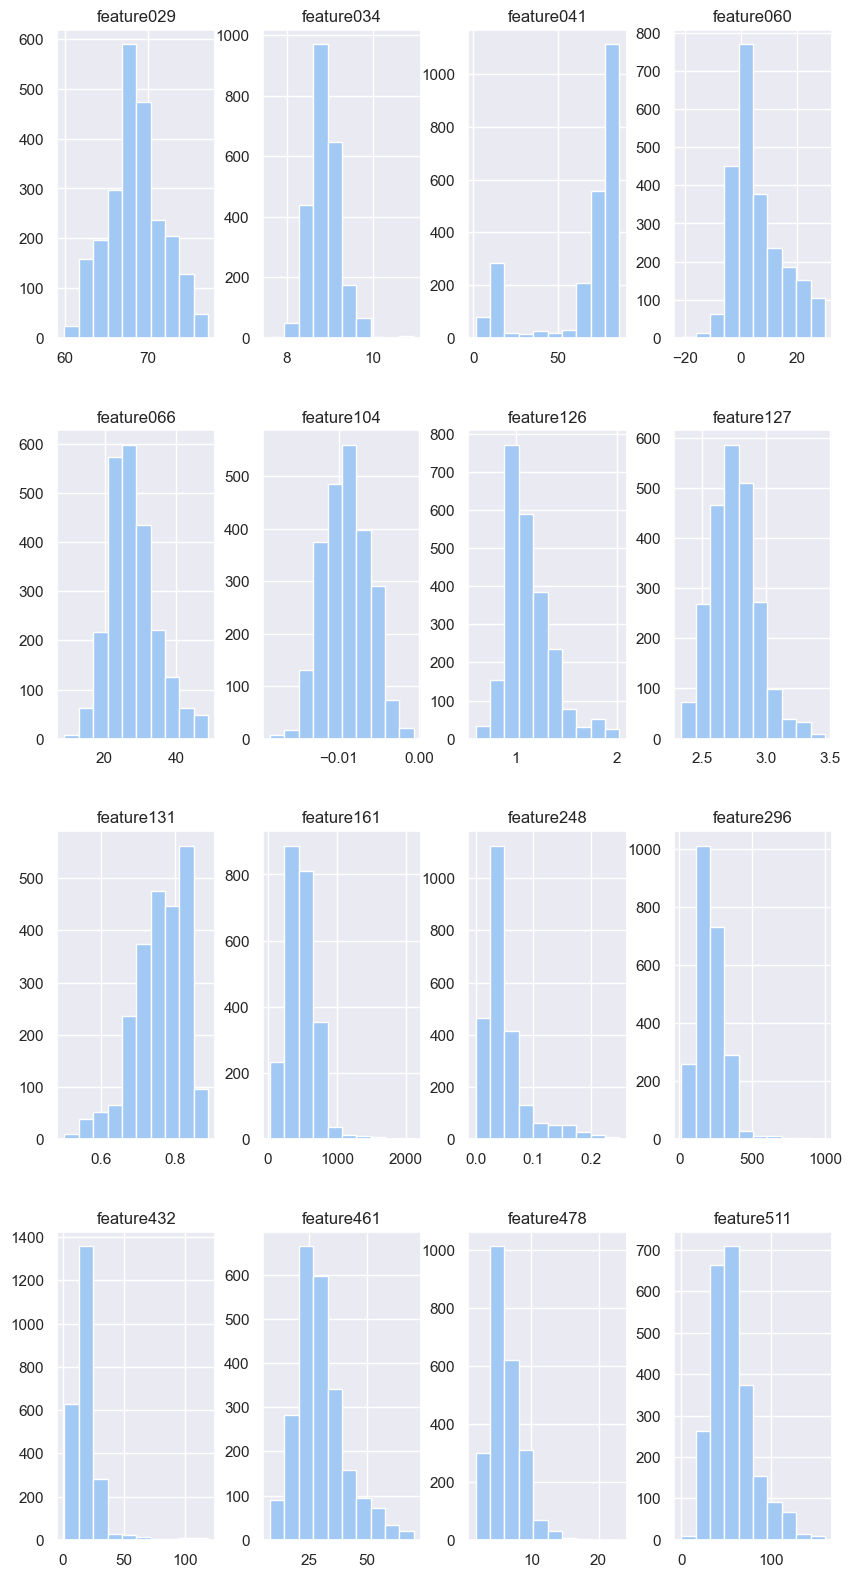

In [204]:
HistogramSubplot(X_train_KNN_Boruta,4,4)

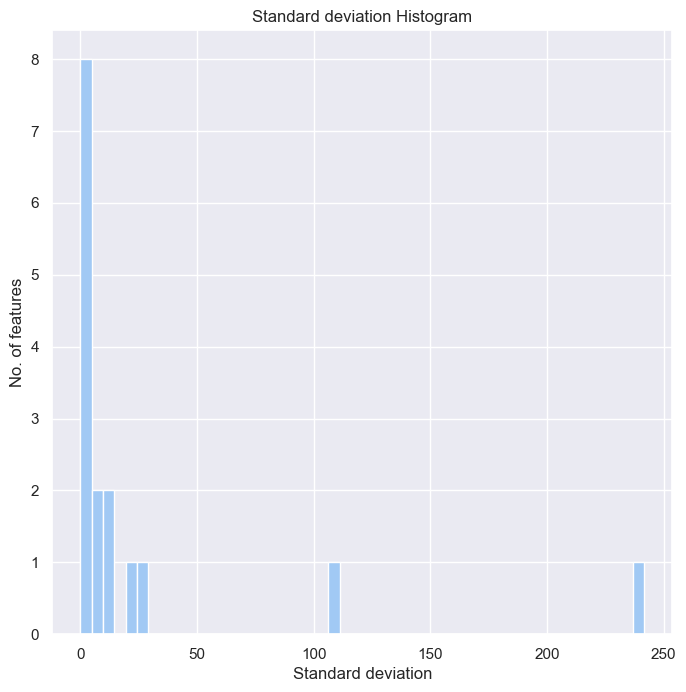

In [59]:
# Histogram of Standard Deviation of the remaining features
StandardDeviation(X_train_KNN_Boruta)

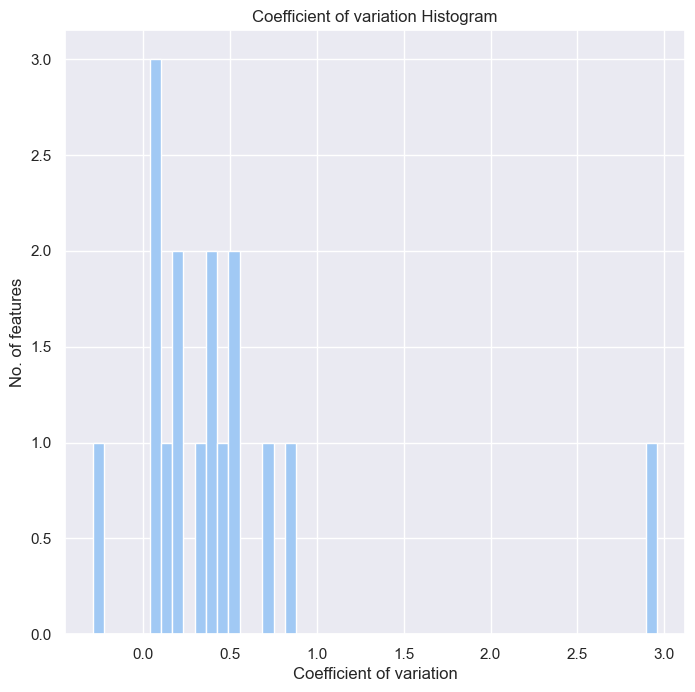

In [60]:
# Histogram of Coefficient of Standard Deviation of the remaining features
CoefficientOfVariation(X_train_KNN_Boruta)

In [61]:
# Correlation of the remaining features

# Heatmap of correlation
corr = pd.DataFrame(X_train_KNN_Boruta.corr())
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,feature029,feature034,feature041,feature060,feature066,feature104,feature126,feature127,feature131,feature161,feature248,feature296,feature432,feature461,feature478,feature511
feature029,1.00,-0.40,0.18,-0.29,-0.15,-0.36,0.18,0.07,-0.05,-0.10,-0.20,-0.10,-0.09,-0.06,-0.11,-0.30
feature034,-0.40,1.00,-0.13,0.16,0.08,0.13,-0.10,-0.00,0.02,0.03,0.09,0.03,0.02,0.08,0.07,0.07
feature041,0.18,-0.13,1.00,-0.10,-0.03,-0.06,0.06,-0.01,-0.01,-0.06,-0.08,-0.07,-0.07,-0.03,-0.05,-0.04
feature060,-0.29,0.16,-0.10,1.00,-0.40,0.36,-0.18,-0.01,0.04,0.11,0.25,0.11,0.05,0.06,0.22,0.30
feature066,-0.15,0.08,-0.03,-0.40,1.00,0.14,-0.02,-0.01,0.01,-0.05,0.09,-0.05,-0.01,0.05,0.01,0.10
feature104,-0.36,0.13,-0.06,0.36,0.14,1.00,-0.23,0.00,0.06,0.13,0.29,0.13,0.10,0.05,0.15,0.63
feature126,0.18,-0.10,0.06,-0.18,-0.02,-0.23,1.00,-0.47,-0.59,-0.06,-0.11,-0.06,-0.05,0.08,-0.06,-0.19
feature127,0.07,-0.00,-0.01,-0.01,-0.01,0.00,-0.47,1.00,0.65,-0.02,-0.01,-0.02,0.00,-0.09,-0.06,0.01
feature131,-0.05,0.02,-0.01,0.04,0.01,0.06,-0.59,0.65,1.00,0.02,0.07,0.03,0.02,-0.09,0.01,0.07
feature161,-0.10,0.03,-0.06,0.11,-0.05,0.13,-0.06,-0.02,0.02,1.00,0.05,0.99,0.64,-0.03,0.04,0.05


In [90]:
# Histogram of the Correlation of the remaining features
correlation(X_train_KNN_Boruta)

NameError: name 'X_train_KNN_Boruta' is not defined

## 5. Modeling

## 5.1. Balancing

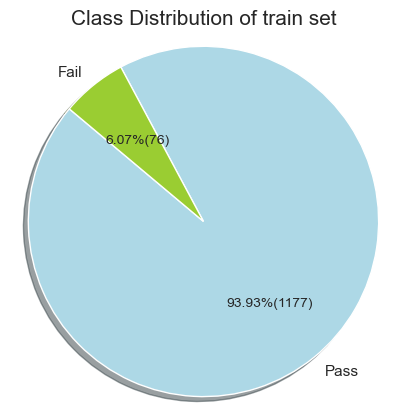

In [189]:
ClassDistributionGraph(y_train, 'Class Distribution of train set')

In [65]:
# transform the dataset
from imblearn.over_sampling import SMOTE

y_train_KNN_Boruta = y_train.copy(deep=True)
oversample = SMOTE()
X_train_KNN_Boruta, y_train_KNN_Boruta = oversample.fit_resample(X_train_KNN_Boruta, y_train_KNN_Boruta)

In [66]:
from collections import Counter
# summarize the new class distribution
counter = Counter(y_train_KNN_Boruta)
print(counter)

Counter({'PASS': 1177, 'FAIL': 1177})


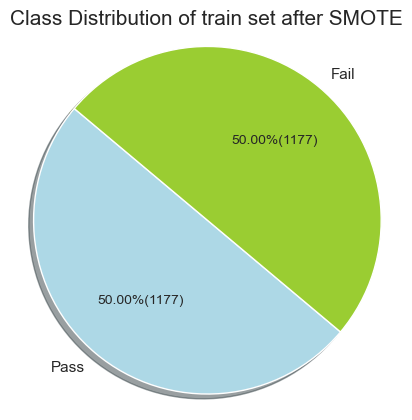

In [191]:
ClassDistributionGraph(y_train_KNN_Boruta, 'Class Distribution of train set after SMOTE')

## 6. Cross Validation

In [67]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=40, shuffle=True)
for train, test in skf.split(X,y):
    print("%s %s" % (train, test))

[   0    3    4 ... 1563 1565 1566] [   1    2   14   22   24   25   35   43   45   52   58   64   72   85
  100  105  130  133  138  142  147  151  156  162  166  174  175  200
  213  241  276  290  317  319  330  335  346  363  374  376  395  397
  403  407  415  421  425  432  464  489  491  507  512  518  552  559
  560  562  566  580  614  620  628  632  636  660  668  689  690  695
  711  718  753  754  758  760  761  768  781  788  800  801  808  844
  846  859  881  891  899  904  910  911  944  968  969  971  990  993
 1000 1004 1006 1047 1048 1067 1080 1097 1107 1128 1144 1166 1171 1193
 1214 1217 1219 1220 1223 1246 1255 1257 1259 1260 1264 1266 1292 1296
 1310 1313 1317 1318 1321 1323 1327 1328 1349 1377 1380 1409 1415 1428
 1429 1442 1445 1452 1474 1486 1488 1511 1512 1516 1517 1522 1531 1544
 1553 1556 1564]
[   0    1    2 ... 1562 1564 1566] [  29   34   46   47   57   62   65   71   73   82   90  114  116  124
  131  134  135  143  146  158  179  192  196  203  205  21

## Preparing Test data

In [68]:
## Rough feature reduction

X_test_KNN_Boruta = X_test.copy(deep=True)
X_test_KNN_Boruta = X_test_KNN_Boruta.drop(columns= 'timestamp')
X_test_KNN_Boruta = X_test_KNN_Boruta.drop(columns= single_value_columns)
X_test_KNN_Boruta = X_test_KNN_Boruta.drop(columns= missing_value_cols)
X_test_KNN_Boruta = X_test_KNN_Boruta.drop(columns= features_least_volatile)
                    
# Outlier treatment 
X_test_KNN_Boruta = Outlier(X_test_KNN_Boruta)

## Missing Value imputation
X_test_KNN_Boruta.iloc[:,:] = pd.DataFrame(MissingValueImputation(X_test_KNN_Boruta,'KNN'))

## Feature selection 
X_test_KNN_Boruta = X_test_KNN_Boruta.filter(final_features)

#SMOTE


X_test_KNN_Boruta



Number of Outliers :  1399


,feature029,feature034,feature041,feature060,feature066,feature104,feature126,feature127,feature131,feature161,feature248,feature296,feature432,feature461,feature478,feature511
ID,,,,,,,,,,,,,,,,
766.0,71.2889,8.7073,77.760,-0.2418,24.7587,-0.0099,1.0590,2.915,0.7697,591.0,0.03160,244.8106,20.8815,18.7707,6.9587,57.7947
1231.0,72.4667,8.8355,76.440,4.6891,14.6060,-0.0088,1.1350,2.545,0.7284,328.0,0.04473,153.2971,12.7478,53.9906,6.0446,52.4964
723.0,74.1333,8.3436,12.190,1.7618,23.5304,-0.0101,0.9554,2.864,0.7585,650.0,0.01980,266.3136,21.5178,10.7413,5.5131,45.6576
1470.0,68.0889,9.7137,81.460,0.0064,23.1671,-0.0126,1.2200,2.897,0.8522,95.0,0.07180,43.8824,3.7721,37.5476,6.8544,27.8884
401.0,67.6778,8.6013,76.970,4.5027,22.3374,-0.0057,1.3470,2.481,0.6834,314.0,0.01420,137.3132,12.1741,17.4238,5.7879,54.0305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28.0,62.8889,8.9336,76.690,17.3873,27.4102,-0.0078,0.9554,3.002,0.6287,420.0,0.03320,177.2362,15.3734,30.4356,5.7628,69.6774
584.0,67.4222,8.7994,2.332,11.2909,13.8957,-0.0111,1.1350,2.467,0.6802,517.0,0.03120,232.9440,19.3000,14.2373,10.7271,39.5062
953.0,72.7667,8.6695,79.210,0.4200,26.5186,-0.0087,1.1820,2.735,0.8349,276.0,0.01880,114.3343,10.6625,29.9729,6.8146,50.4298


## Model

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
%matplotlib inline

In [70]:
def run_ML_process(X, y, X_test, y_test, clf):
    #scaling
    #scaler = StandardScaler()
    #scaler.fit(X)
    #X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)
    #X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    #Evaluation using a 10-fold CV
    scores = cross_val_score(clf, X, y, cv=10, scoring = 'accuracy')
    print('Averace Accuracy:', scores.mean())

    #fit
    clf.fit(X, y)
    
    #predict
    y_pred_test = clf.predict(X_test)
    
    # View accuracy score
    print('Accuracy: ', accuracy_score(y_test, y_pred_test))
    
    #Plot confussion matrix
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(clf, X_test, y_test, ax=ax, cmap=plt.cm.Blues)
    
    # View the classification report for test data and predictions
    print(classification_report(y_test, y_pred_test))
    

### Random Forest

Averace Accuracy: 0.9634745762711864
Accuracy:  0.8980891719745223
              precision    recall  f1-score   support

        FAIL       0.19      0.21      0.20        19
        PASS       0.95      0.94      0.95       295

    accuracy                           0.90       314
   macro avg       0.57      0.58      0.57       314
weighted avg       0.90      0.90      0.90       314



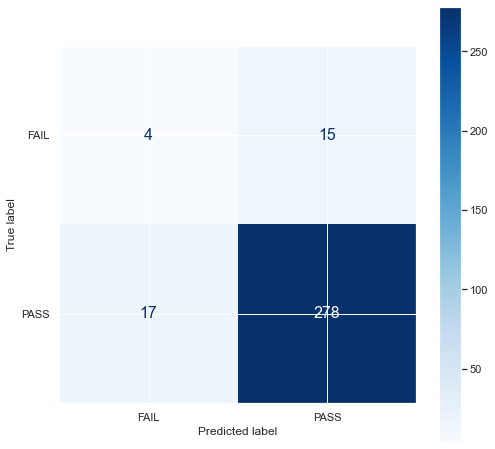

In [71]:
run_ML_process(X_train_KNN_Boruta, y_train_KNN_Boruta, X_test_KNN_Boruta, y_test, RandomForestClassifier())

### Naive Bayes

Averace Accuracy: 0.7421745402091597
Accuracy:  0.7261146496815286
              precision    recall  f1-score   support

        FAIL       0.11      0.47      0.17        19
        PASS       0.96      0.74      0.84       295

    accuracy                           0.73       314
   macro avg       0.53      0.61      0.50       314
weighted avg       0.90      0.73      0.80       314



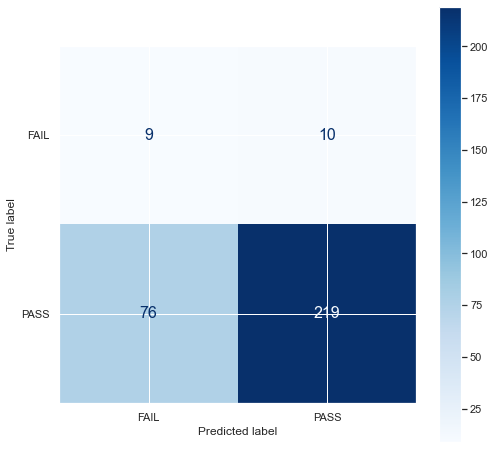

In [72]:
from sklearn.naive_bayes import GaussianNB
run_ML_process(X_train_KNN_Boruta, y_train_KNN_Boruta, X_test_KNN_Boruta, y_test, GaussianNB())

## Decision Tree

Averace Accuracy: 0.8963613415073926
Accuracy:  0.8375796178343949
              precision    recall  f1-score   support

        FAIL       0.15      0.37      0.22        19
        PASS       0.96      0.87      0.91       295

    accuracy                           0.84       314
   macro avg       0.55      0.62      0.56       314
weighted avg       0.91      0.84      0.87       314



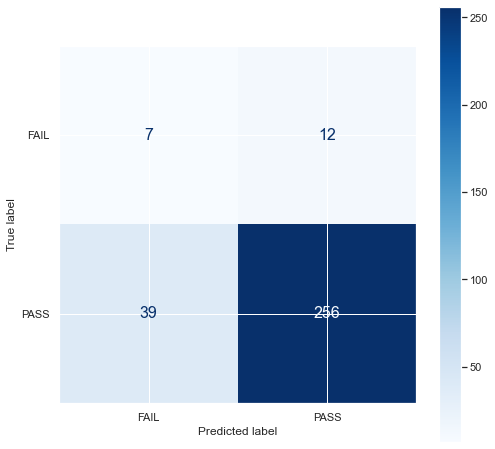

In [73]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
run_ML_process(X_train_KNN_Boruta, y_train_KNN_Boruta, X_test_KNN_Boruta, y_test, DecisionTreeClassifier())

## K nearest neighbor

Averace Accuracy: 0.8717147493689147
Accuracy:  0.7579617834394905
              precision    recall  f1-score   support

        FAIL       0.11      0.42      0.17        19
        PASS       0.95      0.78      0.86       295

    accuracy                           0.76       314
   macro avg       0.53      0.60      0.52       314
weighted avg       0.90      0.76      0.82       314



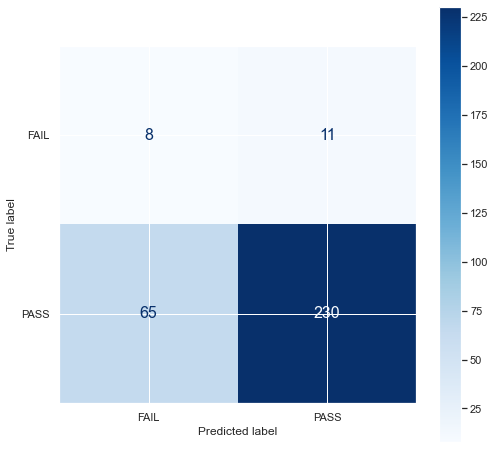

In [74]:
from sklearn.neighbors import KNeighborsClassifier
run_ML_process(X_train_KNN_Boruta, y_train_KNN_Boruta, X_test_KNN_Boruta, y_test, KNeighborsClassifier())

## SVM

Averace Accuracy: 0.7000829426613777
Accuracy:  0.7292993630573248
              precision    recall  f1-score   support

        FAIL       0.08      0.32      0.12        19
        PASS       0.94      0.76      0.84       295

    accuracy                           0.73       314
   macro avg       0.51      0.54      0.48       314
weighted avg       0.89      0.73      0.80       314



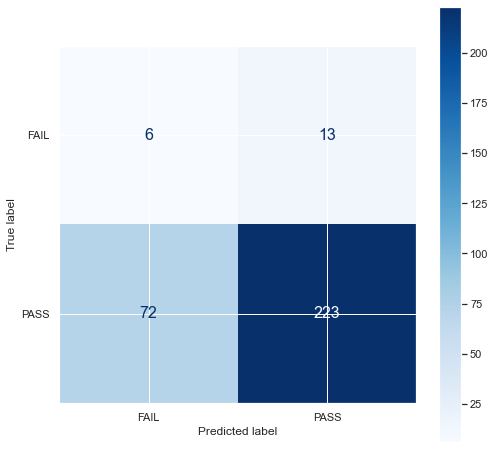

In [75]:
from sklearn.svm import SVC
run_ML_process(X_train_KNN_Boruta, y_train_KNN_Boruta, X_test_KNN_Boruta, y_test, SVC())

## ---------------Imputer = MICE -----------------------------------------------------------------------------------------

#                                                     MICE

## Feature Selelction

#### Boruta

In [193]:
X_train_MICE_Boruta , final_features_MICE = FeatureSelection(X_train_MICE,y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	427
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	400
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	21
Rejected: 	400
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	21
Rejected: 	400
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	21
Rejected: 	400
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	18
Rejected: 	402
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	18
Rejected: 	402
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	18
Rejected: 	402
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	18
Rejected: 	402
Iteration: 	16 / 100
Confirmed: 	8
Tentat

In [194]:
X_train_MICE_Boruta


,feature034,feature060,feature065,feature066,feature104,feature113,feature126,feature127,feature131,feature153,feature161,feature296,feature432,feature461,feature478,feature511,feature520
ID,,,,,,,,,,,,,,,,,
567.0,8.5288,1.4845,18.5155,25.4260,-0.0146,0.455500,0.9649,2.888,0.6627,0.6900,374.0,168.1031,13.6996,22.7157,2.3095,62.3288,4.272400
1261.0,9.0402,1.7273,18.2727,22.1740,-0.0124,0.456906,1.1540,2.627,0.7492,0.2493,227.0,100.6525,8.9011,32.6879,3.4184,21.8402,9.314484
1041.0,8.8581,-3.7509,23.7509,30.7593,-0.0086,0.459908,1.8340,2.658,0.5042,0.9898,225.0,97.2193,8.6034,21.7993,3.3690,39.7080,11.092506
1181.0,8.7782,1.3555,18.6445,22.2300,-0.0107,0.468000,1.0210,2.792,0.7931,0.9841,242.0,106.9279,9.2676,36.7423,4.8659,20.4651,4.490400
611.0,8.5615,2.3900,17.6100,25.5921,-0.0095,0.461525,0.8845,2.748,0.8080,0.7259,418.0,204.2392,15.7706,15.0259,2.9332,68.7831,10.047135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806.0,8.5862,-3.1227,23.1227,31.4849,-0.0111,0.442000,1.2390,2.511,0.6847,0.4626,1047.0,434.9291,38.7634,16.1068,4.6652,45.9459,50.293500
1101.0,8.9818,0.1982,19.8018,23.4628,-0.0116,0.459585,1.4650,2.920,0.8037,0.4269,447.0,206.0362,16.7588,18.7968,2.5177,33.6207,11.983040
1469.0,8.6384,1.2518,18.7482,24.1495,-0.0112,0.457811,1.3800,2.765,0.7248,0.5995,59.0,32.6637,2.6616,31.6738,4.0841,50.7795,9.567299


### Overview of remaining features

In [196]:
# Descriptive statistics
X_train_MICE_Boruta.describe()

,feature034,feature060,feature065,feature066,feature104,feature113,feature126,feature127,feature131,feature153,feature161,feature296,feature432,feature461,feature478,feature511,feature520
count,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000
mean,8.823865,2.737548,20.508914,26.671077,-0.009805,0.461982,1.183274,2.730937,0.746640,0.605968,489.771923,218.097139,17.742723,29.056433,5.625750,52.237593,10.098870
std,0.399681,8.160497,4.937461,8.285294,0.002825,0.005882,0.267227,0.204515,0.080947,0.493642,362.769593,160.896448,12.500311,12.253364,3.147500,24.424030,8.057245
min,7.603200,-21.205500,6.448200,-175.080568,-0.018500,0.398900,0.605500,2.340000,0.501300,0.154400,28.000000,13.622900,1.239100,7.953400,-69.572055,0.000000,0.000000
25%,8.578800,-1.948200,17.362700,22.997000,-0.011800,0.459300,0.974400,2.571000,0.688700,0.371800,295.000000,130.306100,11.056900,20.363900,4.091100,35.320100,5.429400
50%,8.769600,0.860000,20.019337,26.247000,-0.010100,0.461950,1.144000,2.734000,0.758600,0.469600,435.000000,194.398900,16.213400,26.311100,5.243500,47.276100,9.259462
75%,9.035500,4.381800,22.872700,29.921200,-0.008100,0.465000,1.338000,2.857000,0.818700,0.695000,613.000000,270.728000,21.381812,35.748700,6.679000,63.378200,10.804828
max,10.963400,29.750900,49.129022,52.558251,-0.000700,0.488500,2.022000,3.463000,0.888400,5.865800,3386.242195,1507.294477,119.356000,90.481423,23.100200,160.493800,59.664900


In [197]:
#datatype and shape
print(X_train_MICE_Boruta.info())
print(X_train_MICE_Boruta.shape)

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1253 entries, 567.0 to 645.0
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature034  1253 non-null   float64
 1   feature060  1253 non-null   float64
 2   feature065  1253 non-null   float64
 3   feature066  1253 non-null   float64
 4   feature104  1253 non-null   float64
 5   feature113  1253 non-null   float64
 6   feature126  1253 non-null   float64
 7   feature127  1253 non-null   float64
 8   feature131  1253 non-null   float64
 9   feature153  1253 non-null   float64
 10  feature161  1253 non-null   float64
 11  feature296  1253 non-null   float64
 12  feature432  1253 non-null   float64
 13  feature461  1253 non-null   float64
 14  feature478  1253 non-null   float64
 15  feature511  1253 non-null   float64
 16  feature520  1253 non-null   float64
dtypes: float64(17)
memory usage: 208.5 KB
None
(1253, 17)


array([[<AxesSubplot:title={'center':'feature034'}>,
        <AxesSubplot:title={'center':'feature060'}>,
        <AxesSubplot:title={'center':'feature065'}>,
        <AxesSubplot:title={'center':'feature066'}>],
       [<AxesSubplot:title={'center':'feature104'}>,
        <AxesSubplot:title={'center':'feature113'}>,
        <AxesSubplot:title={'center':'feature126'}>,
        <AxesSubplot:title={'center':'feature127'}>],
       [<AxesSubplot:title={'center':'feature131'}>,
        <AxesSubplot:title={'center':'feature153'}>,
        <AxesSubplot:title={'center':'feature161'}>,
        <AxesSubplot:title={'center':'feature296'}>],
       [<AxesSubplot:title={'center':'feature432'}>,
        <AxesSubplot:title={'center':'feature461'}>,
        <AxesSubplot:title={'center':'feature478'}>,
        <AxesSubplot:title={'center':'feature511'}>],
       [<AxesSubplot:title={'center':'feature520'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

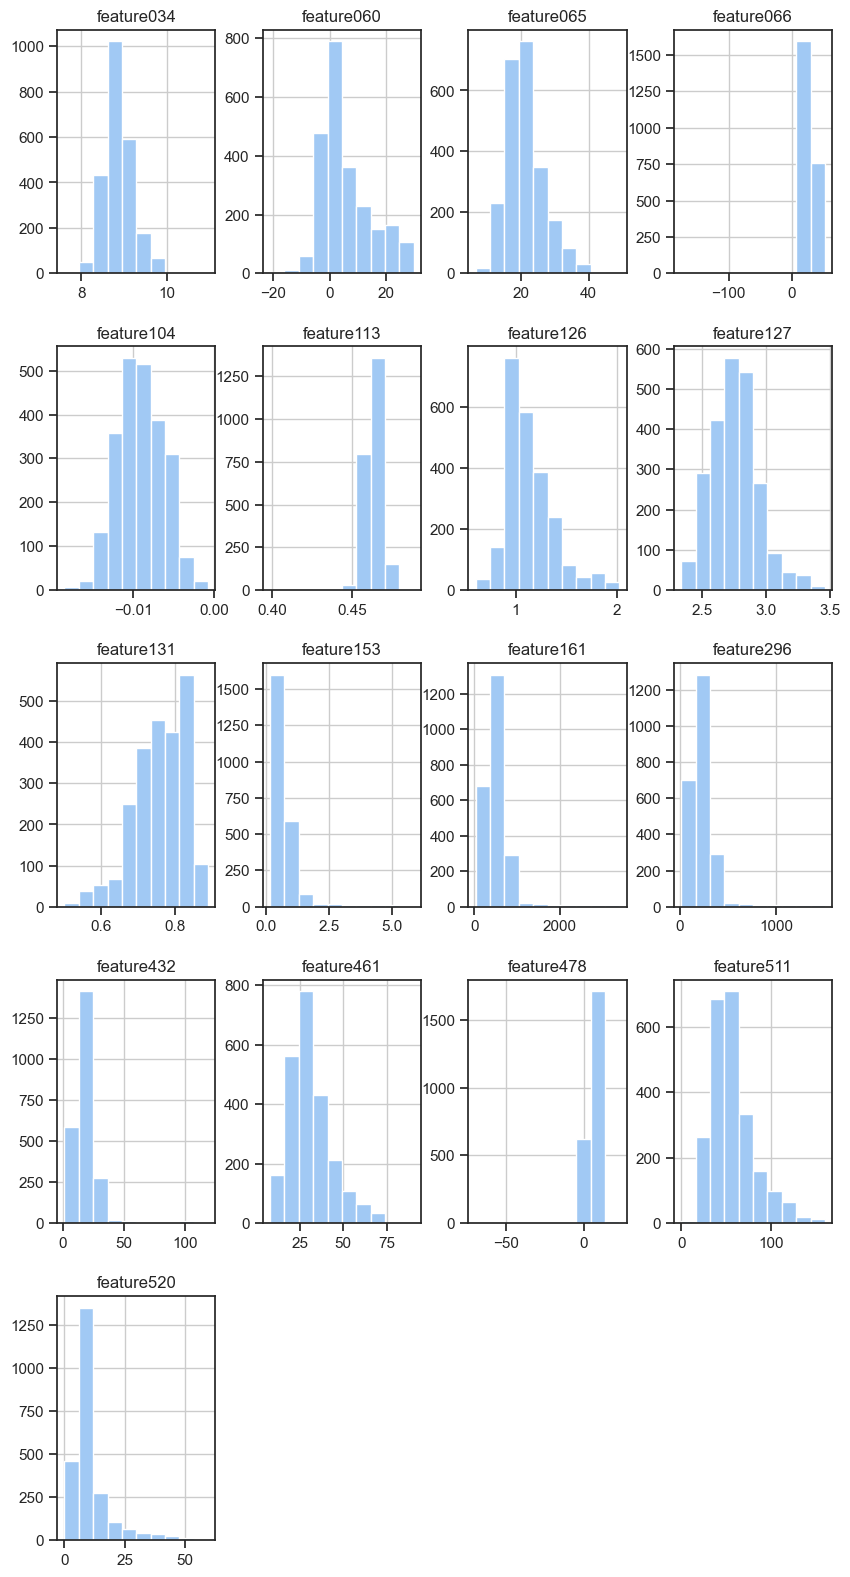

In [264]:
X_train_MICE_Boruta.hist(figsize=(10,20))

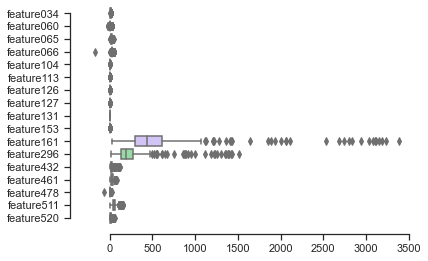

In [218]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot
sns.boxplot(palette=["m", "g"],data=X_train_MICE_Boruta, orient='h')
sns.despine(offset=10, trim=True)

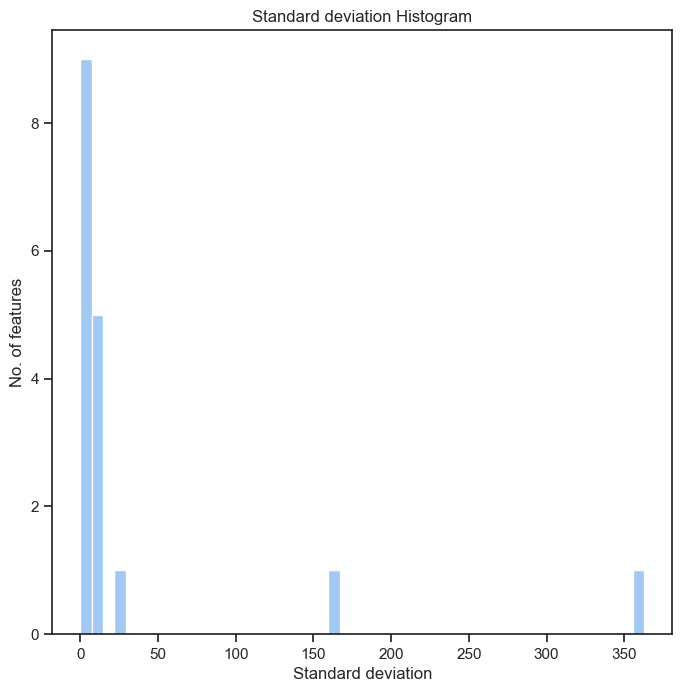

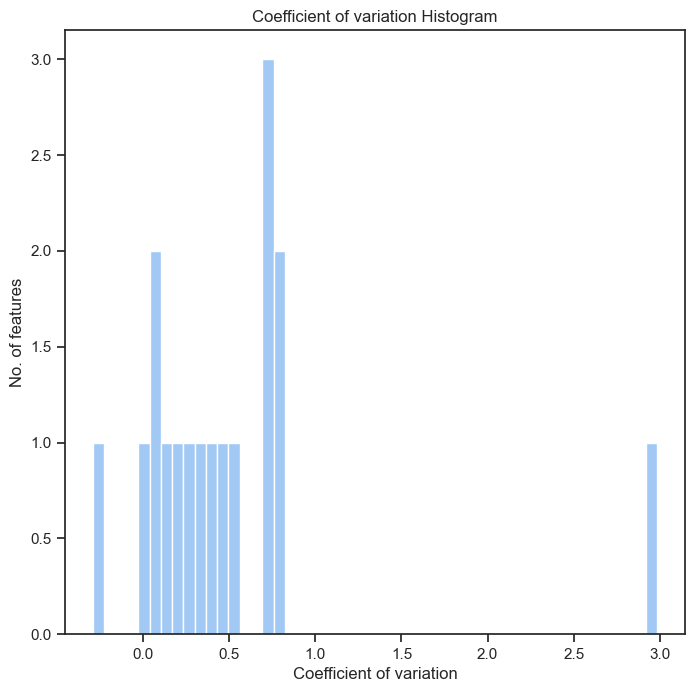

In [221]:
#checking std of features 

StandardDeviation(X_train_MICE_Boruta)

CoefficientOfVariation(X_train_MICE_Boruta)

In [223]:
#Correlation

# Heatmap of correlation
corr = pd.DataFrame(X_train_MICE_Boruta.corr())
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,feature034,feature060,feature065,feature066,feature104,feature113,feature126,feature127,feature131,feature153,feature161,feature296,feature432,feature461,feature478,feature511,feature520
feature034,1.00,0.15,0.08,0.08,0.13,0.16,-0.10,-0.00,0.03,0.03,0.03,0.03,0.03,0.07,0.07,0.07,0.08
feature060,0.15,1.00,-0.46,-0.29,0.35,0.18,-0.18,-0.01,0.04,0.19,0.07,0.07,0.06,0.07,0.17,0.29,0.23
feature065,0.08,-0.46,1.00,0.61,0.13,0.11,0.00,0.00,0.02,-0.04,-0.02,-0.01,-0.01,0.07,-0.10,0.09,0.08
feature066,0.08,-0.29,0.61,1.00,0.11,0.19,-0.04,0.02,0.03,-0.02,-0.01,-0.01,-0.01,0.00,0.46,0.11,0.08
feature104,0.13,0.35,0.13,0.11,1.00,0.16,-0.24,0.01,0.06,0.09,0.12,0.12,0.11,0.03,0.11,0.63,0.27
feature113,0.16,0.18,0.11,0.19,0.16,1.00,-0.05,-0.02,0.01,0.11,0.09,0.09,0.07,0.07,0.16,0.16,-0.09
feature126,-0.10,-0.18,0.00,-0.04,-0.24,-0.05,1.00,-0.49,-0.62,-0.07,-0.07,-0.07,-0.06,0.09,-0.07,-0.19,-0.11
feature127,-0.00,-0.01,0.00,0.02,0.01,-0.02,-0.49,1.00,0.65,-0.01,-0.01,-0.01,-0.00,-0.09,-0.03,0.01,0.01
feature131,0.03,0.04,0.02,0.03,0.06,0.01,-0.62,0.65,1.00,-0.01,0.02,0.02,0.02,-0.09,0.02,0.08,0.08
feature153,0.03,0.19,-0.04,-0.02,0.09,0.11,-0.07,-0.01,-0.01,1.00,0.10,0.11,0.10,0.03,0.05,0.12,0.08


In [224]:
# calculating the z score of the values


z_train_MICE= pd.DataFrame(stats.zscore(X_train_MICE_Boruta,nan_policy='omit'))

# calculating the number of outliers
sum(z_train_MICE.apply(lambda x: sum(x.apply(lambda x: 1 if abs(x)>3 else 0))))

263

## SMOTE

In [225]:
# transform the dataset
from imblearn.over_sampling import SMOTE

oversample_MICE = SMOTE()
X_train_MICE_Boruta , y_train_MICE_Boruta = oversample.fit_resample(X_train_MICE_Boruta, y_train)

In [226]:
from collections import Counter
# summarize the new class distribution
counter = Counter(y_train_MICE_Boruta)
print(counter)

Counter({'PASS': 1177, 'FAIL': 1177})


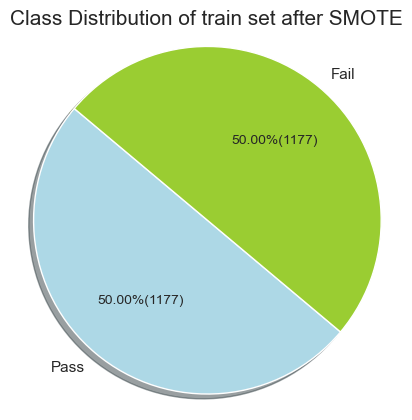

In [227]:
ClassDistributionGraph(y_train_KNN_Boruta, 'Class Distribution of train set after SMOTE')

## Preparing test data

In [250]:
## Rough feature reduction
X_test_MICE_Boruta = X_test.drop(columns = 'timestamp')
X_test_MICE_Boruta = X_test_MICE_Boruta.drop(columns = single_value_columns)
X_test_MICE_Boruta = X_test_MICE_Boruta.drop(columns = missing_value_cols)
X_test_MICE_Boruta = X_test_MICE_Boruta.drop(columns = features_least_volatile)


In [251]:
# Outlier treatment 
X_test_MICE_Boruta = Outlier(X_test_MICE_Boruta)

## Missing Value imputation
X_test_MICE_Boruta.iloc[:,:] = pd.DataFrame(MissingValueImputation(X_test_MICE_Boruta,'MICE'))

## Feature selection 
X_test_MICE_Boruta = X_test_MICE_Boruta.filter(final_features_MICE)

X_test_MICE_Boruta


Number of Outliers :  1399


C:\Users\s0576758\.conda\envs\ML\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



,feature034,feature060,feature065,feature066,feature104,feature113,feature126,feature127,feature131,feature153,feature161,feature296,feature432,feature461,feature478,feature511,feature520
ID,,,,,,,,,,,,,,,,,
766.0,8.7073,-0.2418,20.2418,24.7587,-0.0099,0.464100,1.0590,2.915,0.7697,0.659900,591.0,244.8106,20.8815,18.7707,6.9587,57.7947,6.819300
1231.0,8.8355,4.6891,15.3109,14.6060,-0.0088,0.453422,1.1350,2.545,0.7284,0.491300,328.0,153.2971,12.7478,53.9906,6.0446,52.4964,11.408552
723.0,8.3436,1.7618,18.2382,23.5304,-0.0101,0.456400,0.9554,2.864,0.7585,0.477900,650.0,266.3136,21.5178,10.7413,5.5131,45.6576,4.329800
1470.0,9.7137,0.0064,19.9936,23.1671,-0.0126,0.463659,1.2200,2.897,0.8522,0.210300,95.0,43.8824,3.7721,37.5476,6.8544,27.8884,10.916883
401.0,8.6013,4.5027,15.4973,22.3374,-0.0057,0.455800,1.3470,2.481,0.6834,1.376700,314.0,137.3132,12.1741,17.4238,5.7879,54.0305,3.109100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28.0,8.9336,17.3873,22.6127,27.4102,-0.0078,0.476000,0.9554,3.002,0.6287,-1.745414,420.0,177.2362,15.3734,30.4356,5.7628,69.6774,6.975700
584.0,8.7994,11.2909,8.7091,13.8957,-0.0111,0.459100,1.1350,2.467,0.6802,0.471300,517.0,232.9440,19.3000,14.2373,10.7271,39.5062,6.793900
953.0,8.6695,0.4200,19.5800,26.5186,-0.0087,0.459000,1.1820,2.735,0.8349,0.274300,276.0,114.3343,10.6625,29.9729,6.8146,50.4298,4.102700


## Model

Averace Accuracy: 0.9571150378651281
Accuracy:  0.8757961783439491
              precision    recall  f1-score   support

        FAIL       0.08      0.11      0.09        19
        PASS       0.94      0.93      0.93       295

    accuracy                           0.88       314
   macro avg       0.51      0.52      0.51       314
weighted avg       0.89      0.88      0.88       314



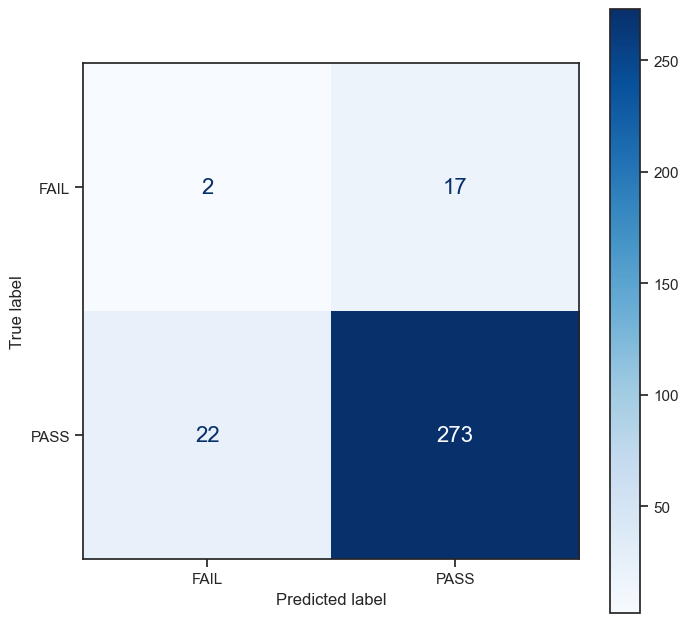

In [252]:
#Random forest
run_ML_process(X_train_MICE_Boruta, y_train_MICE_Boruta, X_test_MICE_Boruta, y_test, RandomForestClassifier() )

Averace Accuracy: 0.7379372520735666
Accuracy:  0.7356687898089171
              precision    recall  f1-score   support

        FAIL       0.09      0.37      0.14        19
        PASS       0.95      0.76      0.84       295

    accuracy                           0.74       314
   macro avg       0.52      0.56      0.49       314
weighted avg       0.90      0.74      0.80       314



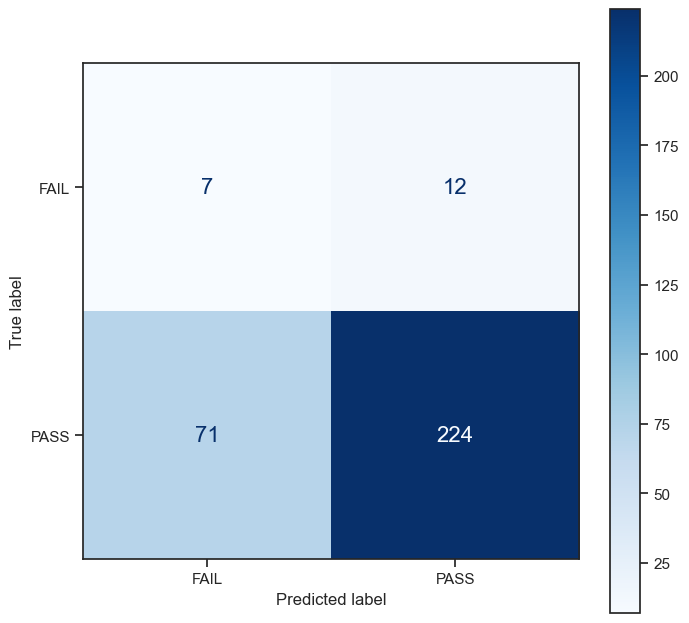

In [253]:
#naive bayes
run_ML_process(X_train_MICE_Boruta, y_train_MICE_Boruta, X_test_MICE_Boruta, y_test, GaussianNB())

Averace Accuracy: 0.8972358456545259
Accuracy:  0.8312101910828026
              precision    recall  f1-score   support

        FAIL       0.15      0.37      0.21        19
        PASS       0.95      0.86      0.91       295

    accuracy                           0.83       314
   macro avg       0.55      0.61      0.56       314
weighted avg       0.91      0.83      0.86       314



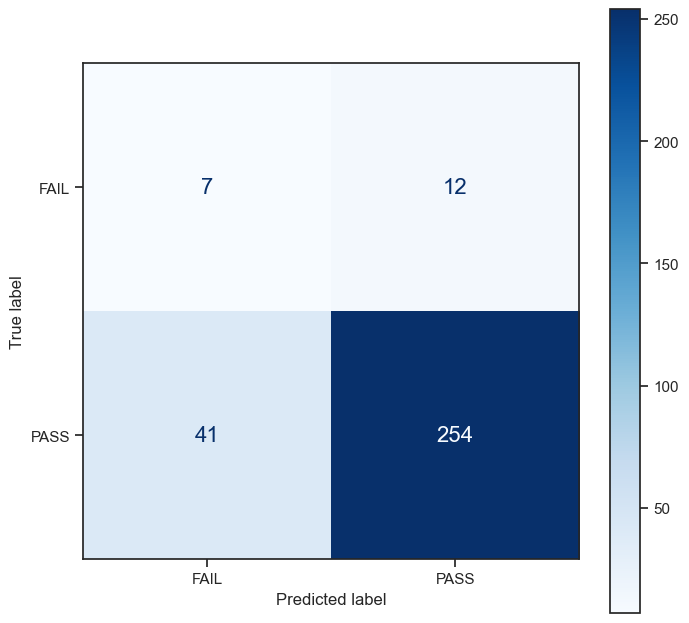

In [254]:
# decision tree
run_ML_process(X_train_MICE_Boruta, y_train_MICE_Boruta, X_test_MICE_Boruta, y_test, DecisionTreeClassifier())

Averace Accuracy: 0.8789433826181032
Accuracy:  0.7420382165605095
              precision    recall  f1-score   support

        FAIL       0.07      0.26      0.11        19
        PASS       0.94      0.77      0.85       295

    accuracy                           0.74       314
   macro avg       0.51      0.52      0.48       314
weighted avg       0.89      0.74      0.80       314



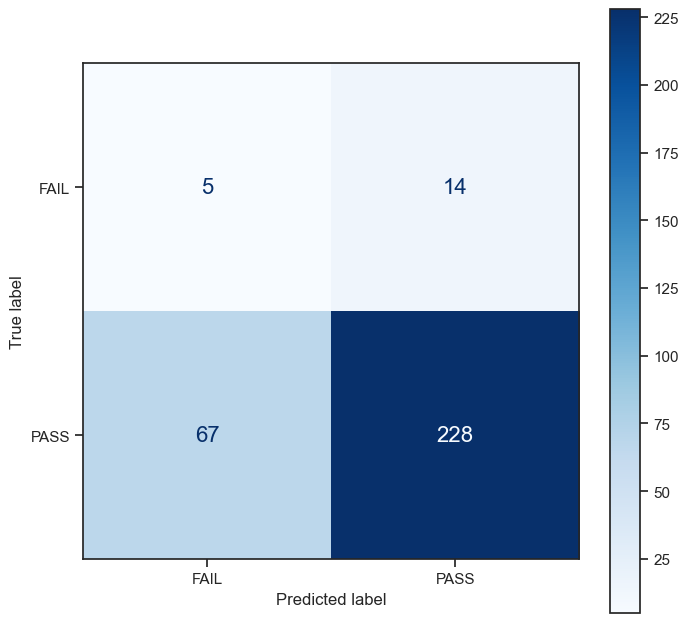

In [255]:
#KNN
run_ML_process(X_train_MICE_Boruta, y_train_MICE_Boruta, X_test_MICE_Boruta, y_test, KNeighborsClassifier())

Averace Accuracy: 0.6894807068157232
Accuracy:  0.589171974522293
              precision    recall  f1-score   support

        FAIL       0.07      0.47      0.12        19
        PASS       0.95      0.60      0.73       295

    accuracy                           0.59       314
   macro avg       0.51      0.54      0.43       314
weighted avg       0.89      0.59      0.69       314



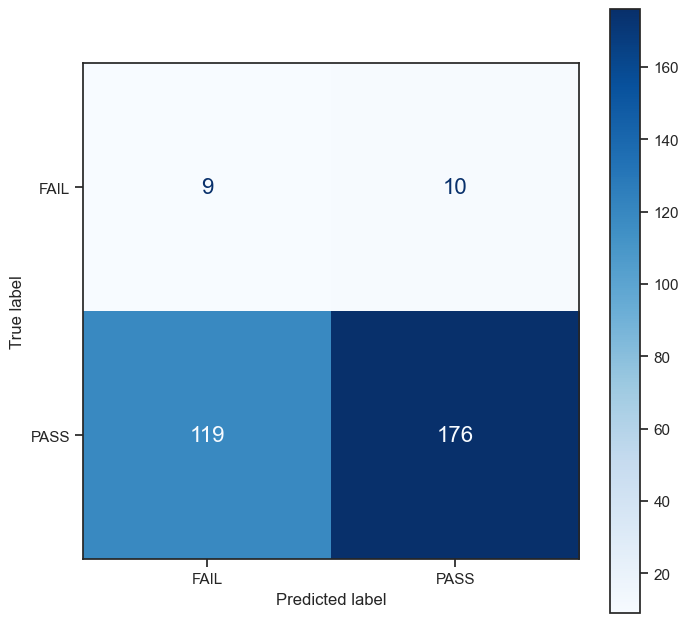

In [256]:
## SVM
run_ML_process(X_train_MICE_Boruta, y_train_MICE_Boruta, X_test_MICE_Boruta, y_test, SVC())

In [ ]:
# calculating the number of outliers
#Z TRANSFORM
scaler = StandardScaler()
scaler.fit(X_train)
a = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)


In [ ]:
demo = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)

In [ ]:
min(list(demo.std()))

In [ ]:
max(list(demo.std()))

In [ ]:
# MIN MAX SCALE
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = pd.DataFrame(min_max_scaler.fit_transform(X_train))
x_scaled

In [ ]:
min(list(x_scaled.std()))

In [ ]:
max(list(x_scaled.std()))